In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import Counter 
import nltk
from nltk.corpus import stopwords
from datetime import datetime, timedelta

In [2]:
data = pd.read_json("data.json")

In [3]:
data.head()

,source,text,created_at,retweet_count,id_str
0,Twitter for iPhone,White House news conference at 5:00 P.M. Easte...,2020-03-30 20:50:35+00:00,14441,1244728753617620992
1,Twitter for iPhone,https://t.co/2hKJkP5Z6N,2020-03-30 17:46:15+00:00,15520,1244682364284014592
2,Twitter for iPhone,"On #NationalDoctorsDay, we recognize the remar...",2020-03-30 17:11:59+00:00,19753,1244673740866191360
3,Twitter for iPhone,https://t.co/nzWJ8ViwbZ,2020-03-30 17:05:33+00:00,39114,1244672122414338048
4,Twitter for iPhone,Nancy Pelosi and the Democrats delayed the Wor...,2020-03-30 11:17:10+00:00,43360,1244584449309892608


In [4]:
print("We have {} tweets.".format(data.shape[0]))
print("\nCheck if we have Null values:")
print(data.count())

We have 13427 tweets.

Check if we have Null values:
source           13427
text             13427
created_at       13427
retweet_count    13427
id_str           13427
dtype: int64


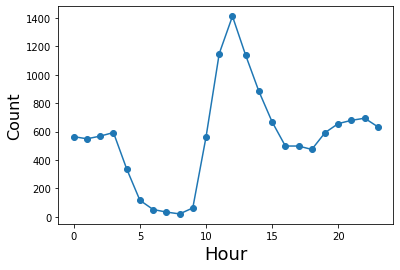

In [5]:
data['hour'] = data["created_at"].dt.hour
hour_count = data["hour"].value_counts().sort_index()
plt.scatter(hour_count.index, hour_count.values)
plt.plot(hour_count.index, hour_count.values)
plt.xlabel('Hour', fontsize=18)
plt.ylabel('Count', fontsize=16)
plt.show()

Interestingly there is a peak at 10pm and 0 - 1 am. Lets find out:

In [6]:
data_3 = data[(data["hour"] >= 0) & (data["hour"] <= 1)]
data_3.head()

,source,text,created_at,retweet_count,id_str,hour
25,Twitter for iPhone,....Federal Government. A quarantine will not ...,2020-03-29 00:19:31+00:00,16651,1244056559577071616,0
26,Twitter for iPhone,On the recommendation of the White House Coron...,2020-03-29 00:19:25+00:00,23918,1244056534583312384,0
41,Twitter for iPhone,"I love Michigan, one of the reasons we are doi...",2020-03-28 01:24:32+00:00,10235,1243710532714192896,1
42,Twitter for iPhone,She is a third rate reporter who has nothing g...,2020-03-28 01:05:07+00:00,17378,1243705647192997888,1
61,Twitter for iPhone,Will be interviewed on @seanhannity at 9:10 P....,2020-03-27 01:05:59+00:00,7419,1243343475799719936,1


The time zone is +00. Lets change it to -5 (eastern time zone, washington).

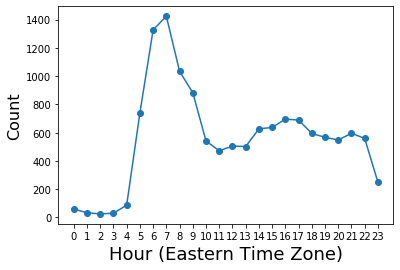

In [7]:
data['created_at_et'] = pd.DatetimeIndex(data['created_at']).tz_convert('US/Central')
data["hour_et"] = data["created_at_et"].dt.hour
hour_count_et = data["hour_et"].value_counts().sort_index()
plt.scatter(hour_count_et.index, hour_count_et.values)
plt.plot(hour_count_et.index, hour_count_et.values)
plt.xticks(np.arange(min(hour_count_et.index) , max(hour_count_et.index)+1, 1.0))
plt.xlabel('Hour (Eastern Time Zone)', fontsize=18)
plt.ylabel('Count', fontsize=16)
plt.show()

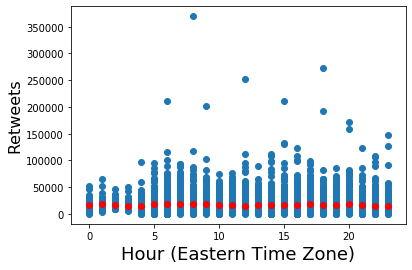

In [8]:

hour_median = data.loc[:, ["retweet_count", "hour_et"]].groupby(['hour_et']).median()
#print(hour_median)
plt.scatter(data['hour_et'], data["retweet_count"])
plt.scatter(hour_median.index, hour_median.loc[:,"retweet_count"], c='red')
plt.xlabel('Hour (Eastern Time Zone)', fontsize=18)
plt.ylabel('Retweets', fontsize=16)
plt.show()


Indicates that the hour of time does not matter for predicting retweets.

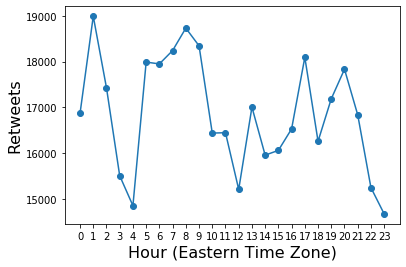

In [9]:

plt.scatter(hour_median.index, hour_median.loc[:,"retweet_count"])
plt.xlabel('Hour (Eastern Time Zone)', fontsize=16)
plt.ylabel('Retweets', fontsize=16)
plt.xticks(np.arange(min(hour_median.index) , max(hour_median.index)+1, 1.0))
plt.plot(hour_median.index, hour_median.loc[:,"retweet_count"])
plt.show()

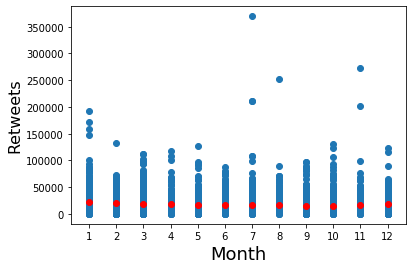

In [10]:
data['month'] = data["created_at"].dt.month
month_median = data.loc[:, ["retweet_count", "month"]].groupby(['month']).median()
#print(hour_median)
plt.scatter(data['month'], data["retweet_count"])
plt.scatter(month_median.index, month_median.loc[:,"retweet_count"], c='red')
plt.xlabel('Month', fontsize=18)
plt.ylabel('Retweets', fontsize=16)
plt.xticks(np.arange(min(month_median.index) , max(month_median.index)+1, 1.0))
plt.show()

Indicates that the month of time does not matter for predicting retweets.

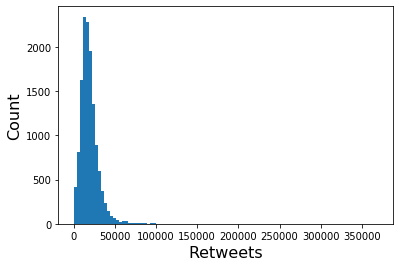

In [11]:
plt.hist(data["retweet_count"], bins = 100)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

Retweet Description:
 count     13427.000000
mean      19149.517986
std       12661.057625
min           0.000000
25%       11898.000000
50%       17132.000000
75%       23767.500000
max      369530.000000
Name: retweet_count, dtype: float64


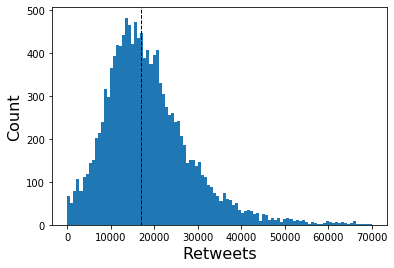

In [12]:
data_2 = data[data["retweet_count"] < 70000].loc[:, "retweet_count"]
print("Retweet Description:\n", data.loc[:, "retweet_count"].describe())
plt.hist(data_2, bins = 100)
plt.axvline(data_2.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

Typical retweet numbers lie between 10.000-20.000. Interestingly there are tweets that have 0 retweets. Lets take a look at tweets with low retweets.

In [13]:
data_low_retweets = data[data["retweet_count"] < 10]
data_low_retweets.loc[:]

,source,text,created_at,retweet_count,id_str,hour,created_at_et,hour_et,month
366,Twitter for iPhone,THANK YOU COLORADO! #KAG2020 https://t.co/a5xx...,2020-03-04 02:49:53+00:00,0,1235034700827283456,2,2020-03-03 20:49:53-06:00,20,3
784,Twitter for iPhone,“What Really Happened”,2020-02-06 03:28:01+00:00,0,1225259827062038528,3,2020-02-05 21:28:01-06:00,21,2
1124,Twitter for iPhone,Why should I have the stigma of Impeachment at...,2020-01-12 16:20:00+00:00,0,1216394407265669120,16,2020-01-12 10:20:00-06:00,10,1
1310,Twitter for iPhone,"...&amp; overwhelming,” but this Scam Impeachm...",2019-12-26 03:10:55+00:00,3,1210035231820058624,3,2019-12-25 21:10:55-06:00,21,12
1454,Twitter for iPhone,https://t.co/sDhHMivMPt,2019-12-16 05:29:54+00:00,4,1206446331675451392,5,2019-12-15 23:29:54-06:00,23,12
4628,Twitter for iPhone,RT @dualtech: #VoterFraud is real. We need #Vo...,2019-08-14 00:57:01+00:00,3,1161441560153743360,0,2019-08-13 19:57:01-05:00,19,8
4851,Twitter for iPhone,....I have directed the Secretary of the Navy ...,2019-07-31 19:56:43+00:00,3,1156654946944737280,19,2019-07-31 14:56:43-05:00,14,7
6988,Twitter for iPhone,Finally great news at the Border! https://t.co...,2019-04-13 02:38:54+00:00,3,1116893495460016128,2,2019-04-12 21:38:54-05:00,21,4
9231,Twitter for iPhone,The White House is running beautifully. We are...,2018-09-10 11:30:49+00:00,6,1039113964892966912,11,2018-09-10 06:30:49-05:00,6,9
10571,Twitter for iPhone,.@JimRenacci has worked so hard on Tax Reducti...,2018-04-24 19:05:40+00:00,8,988856517674889216,19,2018-04-24 14:05:40-05:00,14,4


If you go back to the site http://www.trumptwitterarchive.com/archive you can see that every tweet here is not availabe anymore. It was probably posted and shortly after deleted. For example the tweet with the ID 366 (first row in the above table) has 0 retweets, which is deleted. But Trump posted the exact same tweet one minute after this tweet and it got 8000 retweets: https://twitter.com/realdonaldtrump/status/1235034836705959936.

So one conclusion one can take is that some tweets that are in our database where being posted but soon after deleted. The question is which tweets those are (minimum retweets?) and how we will deal with them.

Retweet Description:
 count     457.000000
mean     2191.645514
std      1158.813351
min         0.000000
25%      1347.000000
50%      2386.000000
75%      3123.000000
max      3998.000000
Name: retweet_count, dtype: float64


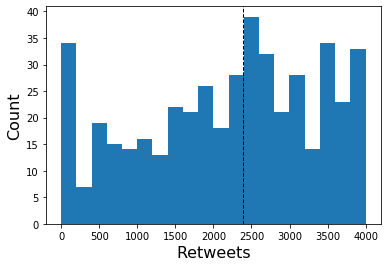

In [14]:
data_2 = data[data["retweet_count"] < 4000].loc[:, "retweet_count"]
print("Retweet Description:\n", data_2.describe())
plt.hist(data_2, bins = 20)
plt.axvline(data_2.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

In [15]:
dublicates = data.loc[:, ["text"]].duplicated()
data[dublicates]

,source,text,created_at,retweet_count,id_str,hour,created_at_et,hour_et,month
137,Twitter for iPhone,https://t.co/ytgBP3hJv1,2020-03-20 18:45:23+00:00,31863,1241073365898727424,18,2020-03-20 13:45:23-05:00,13,3
391,Twitter for iPhone,Australia’s Central Bank cut interest rates an...,2020-03-03 06:27:46+00:00,643,1234727146964254720,6,2020-03-03 00:27:46-06:00,0,3
606,Twitter for iPhone,“Judge Jackson now has a request for a new tri...,2020-02-18 15:21:28+00:00,954,1229788024931803136,15,2020-02-18 09:21:28-06:00,9,2
607,Twitter for iPhone,....THE UNITED STATES IS OPEN FOR BUSINESS!,2020-02-18 15:21:28+00:00,786,1229788026773131264,15,2020-02-18 09:21:28-06:00,9,2
608,Twitter for iPhone,....THE UNITED STATES IS OPEN FOR BUSINESS!,2020-02-18 14:37:05+00:00,3374,1229776855265349632,14,2020-02-18 08:37:05-06:00,8,2
...,...,...,...,...,...,...,...,...,...
12653,Twitter for iPhone,MAKE AMERICA GREAT AGAIN!,2017-06-24 21:23:52+00:00,46890,878725385235701760,21,2017-06-24 16:23:52-05:00,16,6
12780,Twitter for iPhone,MAKE AMERICA GREAT AGAIN!,2017-06-02 01:00:35+00:00,48844,870445001125355520,1,2017-06-01 20:00:35-05:00,20,6
12808,Twitter for iPhone,Does anyone notice how the Montana Congression...,2017-05-28 12:40:33+00:00,848,868809214365487104,12,2017-05-28 07:40:33-05:00,7,5
13331,Twitter for Android,MAKE AMERICA GREAT AGAIN!,2017-02-04 14:26:10+00:00,66140,827885966509604864,14,2017-02-04 08:26:10-06:00,8,2
